# Модель предпочтительного присоединения

В некоторую структуру (университет) последовательно, один за другим, прибывают новые
объекты (студенты). Первый прибывший создает структуру (клуб). Каждый очередной объект
с небольшой вероятностью $p$ создает новый клуб, или с вероятностью $1-p$ присоединятеся к
одному из уже имеющихся.

Вероятность присоединения к данному клубу пропорциональна его
размеру (числу членов), деленному на общее количество уже прибывших к данному моменту

Реализуем клубную систему

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
class ClubSystem:
    
    def __init__(self, p = 0.1, clubs = []):
        self.p = p
        self.clubs = clubs
        self.peopleNum = 0
        self.weights = []
        if len(self.clubs) > 0:
            self.peopleNum = sum(self.clubs)
        self.weights = self.updateWeights()
        
    def step(self):
        if np.random.rand() < self.p or len(self.clubs) == 0:
            self.clubs.append(1)
        else:
            club = random.choices([m for m in range(len(self.clubs))], weights=self.weights, k = 1)[0]
            self.clubs[club] += 1
        self.peopleNum += 1
        self.updateWeights()
            
    def updateWeights(self):
        if len(self.clubs) == 0:
            self.weights = []
            return
        self.weights = [k / self.peopleNum for k in self.clubs]
        
    def log_likelihood(self, alpha):
        n = len(self.clubs)
        clubs = np.array(self.clubs)
        clubs = clubs[:, np.newaxis]
        return n * np.log(alpha) - alpha * np.sum(clubs)
    
    def find_alpha(self):
        return len(self.clubs) / self.peopleNum
            

Смоделируем поступление 100 студентов, зададим вероятность создания нового клуба $p=0.3$

In [3]:
people_max = 2500
p = 0.3

itmo_clubs = ClubSystem(p=p)

In [4]:
for _ in range(people_max):
    itmo_clubs.step()

Text(0, 0.5, 'Число участников')

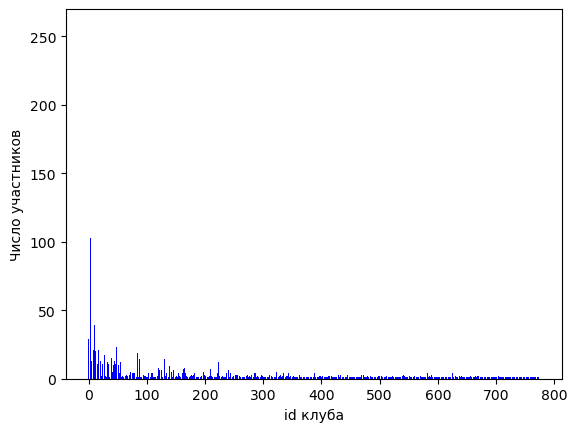

In [5]:
plt.bar((range(len(itmo_clubs.clubs))), itmo_clubs.clubs, color='blue')
plt.xlabel("id клуба")
plt.ylabel("Число участников")

Определим распределение клубов по числу участников

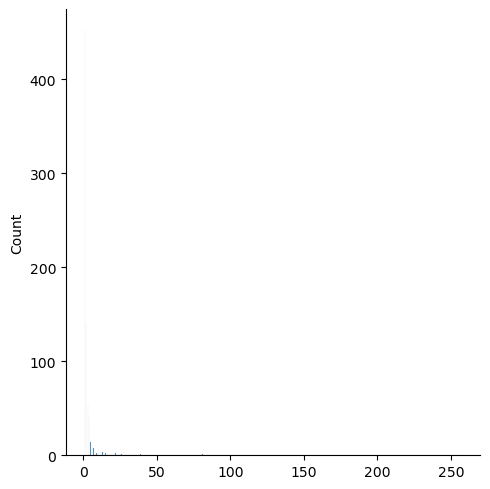

In [6]:
sns.displot(itmo_clubs.clubs)

Предположим, что получилось экспоненциально распределение с плотностью вероятности вида $f(x) = \alpha x^{-\alpha}$.

Найдём $\alpha$ при помощи ММП:

$$
    \mathcal{L} = \prod\limits_{i=1}^{n}f(X_i = x_i) = \alpha^n \prod\limits_{i=1}^{n}e^{-\alpha x_i} = \alpha^n e^{-\alpha\sum\limits_i^{n}x_i}
$$

$$
    \ln\mathcal{L} = n\ln \alpha - \alpha \sum\limits_{i=1}^{n} x_i \rightarrow \max
$$

$$
    \dfrac{d}{d \alpha} \ln \mathcal{L} = \dfrac{n}{\alpha} - \sum\limits_{i=1}^{n} x_i = 0
$$

$$
    \alpha = \dfrac{n}{\sum\limits_{i=1}^n x_i} = \dfrac{1}{\bar{X}}
$$


Возьём $\alpha$, при котором достигается максимум

In [7]:
opt_alpha = itmo_clubs.find_alpha()
print(opt_alpha)

0.31


Теперь попробуем найти зависимость $\alpha(p)$.

In [9]:
p_vals = []
a_vals = []
        
for p in np.arange(0.01, 1, 0.1):
    club = ClubSystem(p)
    for _ in range(people_max):
        club.step()
    alpha = club.find_alpha()
    p_vals.append(p)
    a_vals.append(alpha)
p_vals = np.array(p_vals)
a_vals = np.array(a_vals)

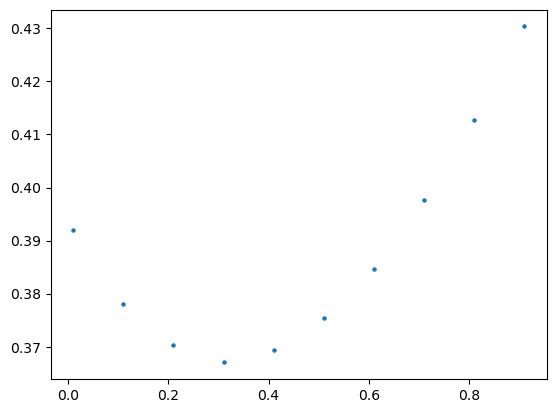

In [10]:
plt.scatter(p_vals, a_vals,s=5)
# plt.semilogy()

По большей части зависимость похожа на экспоненциальную

In [13]:
def calc_determination(data_x, data_y, coeffs):
    approx_y = np.polyval(coeffs, data_x)
    y_dev = np.sum((data_y - np.mean(data_y))**2)
    approx_dev = np.sum((approx_y - data_y)**2)
    return np.round(1 - approx_dev / y_dev, 2)

def approx_data(data_x, data_y, deg = 1):
    coeffs = np.polyfit(data_x, data_y, deg)
    determination = calc_determination(data_x, data_y, coeffs)
    return coeffs, determination

In [ ]:
p_ax = np.linspace(0, 1)
coeffs, r = approx_data(p_vals, a_vals, deg=2)
fit_a = np.polyval(coeffs, p_ax)

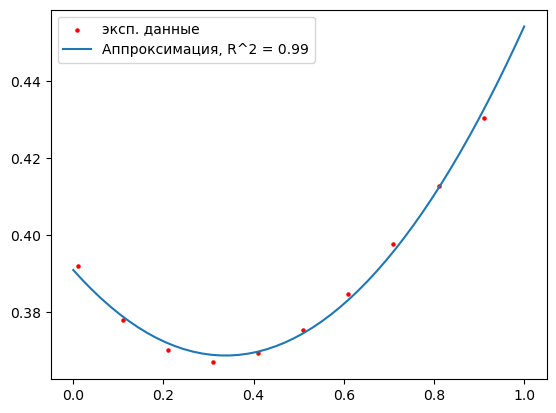

In [16]:
plt.scatter(p_vals, a_vals,s=5, label='эксп. данные', color='red')
plt.plot(p_ax, fit_a, label=f'Аппроксимация, R^2 = {r}' )
plt.legend()

Зависимость параметра распределения от вероятности при $n=2500$ выглядит как парабола